# DeLDRify - ESRGAN applied to single-track LDR to HDR image conversion

## Import and initalize the models

In [1]:
import torch

device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
device

'mps'

In [2]:
config = {
            "RGBE": True,
            "in_nc":3,
            "nf":64,
            "nb":4,
            "gc":32,
            "out_channels":4,
            "channels":16,
            "nb_images":10,
            "batch_size":2,
            "epochs":400,
            "loss_scaling_factor":1e-3,
        }

if config["RGBE"]:
    config["in_channels"] = 4
    config["out_nc"] = 4
else:
    config["in_channels"] = 3
    config["out_nc"] = 3


In [3]:
from generator import RRDBNet
from discriminator import DiscriminatorForVGG

G = RRDBNet(in_nc=config["in_nc"], out_nc=config["out_nc"], nf=config["nf"], nb=config["nb"], gc=config["gc"])
D = DiscriminatorForVGG(in_channels=config["in_channels"], out_channels=config["out_channels"], channels=config["channels"])

G.to(device=device)
D.to(device=device);

In [4]:
print("Number of param (G):", sum(p.numel() for p in G.parameters()) / 1_000_000, "M")
print("Number of param (D):", sum(p.numel() for p in D.parameters()) / 1_000_000, "M")

Number of param (G): 2.918724 M
Number of param (D): 1.061864 M


## Prepare the data

In [5]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Resize((128, 128), antialias=None), 
])

In [6]:
from custom_datasets import PairWiseImages, PairWiseImagesRGBE

### RGBE format
if config["RGBE"]:
    pair = PairWiseImagesRGBE("LDR-HDR-pair_Dataset-master/LDR_exposure_0/", 
                        "LDR-HDR-pair_Dataset-master/HDR/", 
                        transform=train_transform, device=device)
    
### Original dataset RGB format
else:
    pair = PairWiseImages("LDR-HDR-pair_Dataset-master/LDR_exposure_0/", 
                        "LDR-HDR-pair_Dataset-master/HDR/", 
                        transform=train_transform, device=device)


In [7]:
import torch
from torch.utils.data import Subset

if config["nb_images"] > len(pair):
    raise ValueError("Number of images to train is greater than the dataset size")

elif config["nb_images"] == -1 or config["nb_images"] == len(pair):
    print("Training on the whole dataset")
    pair_subset = pair
else:
    print("Training on a subset of the dataset")
    indices = torch.arange(config["nb_images"])
    pair_subset = Subset(pair, indices)

Training on a subset of the dataset


In [8]:
import torch

length = len(pair_subset)
test_length = int(0.2 * length)

train, valid = torch.utils.data.random_split(pair_subset, [length - test_length, test_length])

In [9]:
BATCH_SIZE = config["batch_size"]

train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
valid_data_loader = torch.utils.data.DataLoader(valid, batch_size=BATCH_SIZE, shuffle=True)
len(train_dataloader), len(valid_data_loader)

(4, 1)

In [21]:
import os

def save_ckp(checkpoint, checkpoint_dir, suffix=""):
    old_path = f"{checkpoint_dir}/checkpoint_{suffix}_{checkpoint['epoch']-1}.pt"
    if os.path.exists(old_path):
        os.remove(old_path)
    f_path = f"{checkpoint_dir}/checkpoint_{suffix}_{checkpoint['epoch']}.pt"
    torch.save(checkpoint, f_path)

def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']

## Train the models

In [11]:
import wandb
wandb.login()

run = wandb.init(
                    project="DeLDRify",
                    config=config,
                )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: oskarjor (deldrify). Use `wandb login --relogin` to force relogin


In [12]:
criterion_pixel = torch.nn.L1Loss().to(device)
criterion_GAN = torch.nn.BCEWithLogitsLoss().to(device)

In [13]:
from datetime import datetime

results_dir = './cache-' + run.name
results_dir

'./cache-feasible-feather-20'

In [14]:
from tqdm.notebook import tqdm
import os
import numpy as np

retrain = False
d_path = "cache-peachy-dawn-11/checkpoint_discriminator_20.pt"
g_path = "cache-peachy-dawn-11/checkpoint_generator_20.pt"

epochs = config["epochs"]

optimizer_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.9, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.9, 0.999))

loss_scaling_factor = config["loss_scaling_factor"]

if not os.path.exists(results_dir):
        os.mkdir(results_dir)

import json
with open(results_dir + '/metadata.json', 'w') as fp:
    json.dump(config, fp)


if retrain:
    G, optimizer_G, start_epoch = load_ckp(g_path, G, optimizer_G)
    D, optimizer_D, start_epoch = load_ckp(d_path, D, optimizer_D)
    epochs = epochs + start_epoch
    print(f"Resuming training from epoch {start_epoch}")
else:
    start_epoch = 0

for epoch in tqdm(range(start_epoch,epochs)):
    total_loss_G = 0
    total_loss_D = 0
    total_loss_D_real = 0
    total_loss_D_fake = 0

    for ldr, hdr in tqdm(train_dataloader, leave=False):

        D_output_shape = D.out_channels

        valid = torch.tensor(np.ones((ldr.size(0), D_output_shape)), requires_grad=False, dtype=torch.float32).to(device=device)
        fake = torch.tensor(np.zeros((ldr.size(0), D_output_shape)), requires_grad=False, dtype=torch.float32).to(device=device)

        # Train Generator
        optimizer_G.zero_grad()

        fake_hdr = G(ldr)

        loss_pixel = criterion_pixel(fake_hdr, hdr)

        pred_real = D(hdr).detach()
        pred_fake = D(fake_hdr)

        loss_GAN = criterion_GAN(pred_fake - pred_real.mean(0, keepdim=True), valid)

        loss_G = loss_pixel + loss_scaling_factor * loss_GAN
        total_loss_G += loss_G.item()

        loss_G.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()

        pred_real = D(hdr)
        pred_fake = D(fake_hdr.detach())

        loss_real = criterion_GAN(pred_real - pred_fake.mean(0, keepdim=True), valid)
        loss_fake = criterion_GAN(pred_fake - pred_real.mean(0, keepdim=True), fake)

        loss_D = (loss_real + loss_fake) / 2
        total_loss_D_real += loss_real.item()
        total_loss_D_fake += loss_fake.item()
        total_loss_D += loss_D.item()

        loss_D.backward()
        optimizer_D.step()

    wandb.log({"loss_G": total_loss_G / len(train_dataloader), "loss_D": total_loss_D / len(train_dataloader), "loss_D_real": total_loss_D_real / len(train_dataloader), "loss_D_fake": total_loss_D_fake / len(train_dataloader), "epoch": epoch+1})

    checkpoint_G = {
        'epoch': epoch + 1,
        'state_dict': G.state_dict(),
        'optimizer': optimizer_G.state_dict(),
    }

    checkpoint_D = {
        'epoch': epoch + 1,
        'state_dict': D.state_dict(),
        'optimizer': optimizer_D.state_dict(),
    }

    save_ckp(checkpoint_G,results_dir,"generator")
    save_ckp(checkpoint_D,results_dir,"discriminator")

wandb.finish()

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/Users/oskarjor/miniconda3/envs/hdrgan/lib/python3.9/site-packages/torch/autograd/__init__.py:251: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss_D,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_D_fake,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_D_real,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_G,█▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,400
loss_D,1e-05
loss_D_fake,1e-05
loss_D_real,1e-05
loss_G,0.07742


## Load the model and do inference

In [ ]:
from utils import RGBE_to_RGB, preprocess_tensor_to_array
from utils import hdr_np_to_img_manual, hdr_np_to_img_tonemap, np_to_img_naive



# load data from train dataset onto cpu
ldr, hdr = train[0]
ldr = preprocess_tensor_to_array(ldr, RGBE=False)
hdr = preprocess_tensor_to_array(hdr, RGBE=config["RGBE"])

# convert from RGBE to RGB
if config["RGBE"]:
    hdr = RGBE_to_RGB(hdr.copy())

# create PIL images (naive approach)
ldr_img = np_to_img_naive(ldr)
hdr_img = np_to_img_naive(hdr)

# create PIL images (tonemap approach)
new_hdr_img = hdr_np_to_img_manual(hdr)
new_hdr2_img = hdr_np_to_img_tonemap(hdr)

# list of images to display
images = [ldr_img, hdr_img, new_hdr_img, new_hdr2_img]

# display images
display(*images)

In [23]:
from generator import RRDBNet
from discriminator import DiscriminatorForVGG
import torch
import json

# cache to read model weights from
target_dir = "cache-feasible-feather-20"
config_path = target_dir + "/metadata.json"
with open(config_path) as conf_file:
    config = json.load(conf_file)

# create models
G = RRDBNet(in_nc=config["in_nc"], out_nc=config["out_nc"], nf=config["nf"], nb=config["nb"], gc=config["gc"])
D = DiscriminatorForVGG(in_channels=config["in_channels"], out_channels=config["out_channels"], channels=config["channels"])

# load weights
G, _, _ = load_ckp(target_dir + "/checkpoint_generator_400.pt", G, None)
D, _, _ = load_ckp(target_dir + "/checkpoint_discriminator_400.pt", D, None)

# move models to device (cpu, cuda or mps)
G.to(device=device)
D.to(device=device);

In [24]:
# load a batch from the validation dataset
ldr, hdr = next(iter(valid_data_loader))

# create a real, generated and random HDR image
real_hdr = hdr
fake_hdr = G(ldr)
random_hdr = torch.rand_like(hdr)

# run discriminator on the images
print("Real HDR images (values should be positive)")
print(D(hdr).mean(0, keepdim=True).detach())
print()

print("Random HDR images (values should be negative)")
print(D(random_hdr).mean(0, keepdim=True).detach())
print()

print("Generated HDR images (values should be positive for a good generator, and negative for a good discriminator)")
print(D(fake_hdr).mean(0, keepdim=True).detach())
print()

Real HDR images (values should be positive)
tensor([[-3.2827, -3.0198, -3.7970, -4.4550]], device='mps:0')

Random HDR images (values should be negative)
tensor([[-0.7784, -0.6135, -1.0555, -1.4221]], device='mps:0')

Generated HDR images (values should be positive for a good generator, and negative for a good discriminator)
tensor([[-5.2819, -5.1296, -6.1361, -6.8203]], device='mps:0')



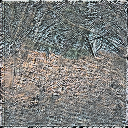

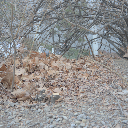

In [52]:
from utils import RGBE_to_RGB, preprocess_tensor_to_array, hdr_np_to_img_manual, hdr_np_to_img_tonemap

IMG_INDEX = 1

fake_arr = preprocess_tensor_to_array(fake_hdr[IMG_INDEX].detach(), RGBE=config["RGBE"])
if config["RGBE"]:
    fake_arr_RGB = RGBE_to_RGB(fake_arr)
    fake_hdr_indices = fake_arr_RGB > 1
    fake_img = hdr_np_to_img_tonemap(fake_arr_RGB)
else:
    fake_img = hdr_np_to_img_tonemap(fake_arr)

real_arr = preprocess_tensor_to_array(real_hdr[IMG_INDEX].detach(), RGBE=config["RGBE"])
if config["RGBE"]:
    real_arr_RGB = RGBE_to_RGB(real_arr)
    real_img = hdr_np_to_img_tonemap(real_arr_RGB)
else:
    real_img = hdr_np_to_img_tonemap(real_arr)

display(fake_img, real_img)

In [65]:
real_hdr_indices = real_arr_RGB > 1
fake_hdr_indices = fake_arr_RGB > 1

np.count_nonzero(1 - real_hdr_indices)

48279

In [70]:
import PIL.Image

np_real_img = np.array(real_img)
R = np_real_img[:, :, 0]
G = np_real_img[:, :, 1]
B = np_real_img[:, :, 2]
np_real_img[real_arr_RGB < 1] = 255
real_img_filtered = PIL.Image.fromarray(np_real_img)
real_img_filtered

AttributeError: 'int' object has no attribute 'dtype'

In [64]:
np.unique(np_real_img, return_counts=True)

(array([  0, 255], dtype=uint8), array([  873, 48279]))

In [ ]:
import cv2 as cv

cv.imwrite("fake_img.hdr", np.array(fake_img))  # save image

## Assert that RGB -> RGBE -> RGB conversion is valid

In [ ]:
import cv2 as cv
from utils import RGBE_to_RGB, RGB_to_RGBE

np_hdr = cv.imread("LDR-HDR-pair_Dataset-master/HDR/HDR_001.hdr", flags=cv.IMREAD_ANYDEPTH)
print(np_hdr.shape, np_hdr.dtype, np_hdr.max(), np_hdr.min(), sep="\n")

In [ ]:
converted_hdr = RGB_to_RGBE(np_hdr)
print(converted_hdr.shape, converted_hdr.dtype, converted_hdr.max(), converted_hdr.min(), sep="\n")

In [ ]:
converted_hdr_exp = converted_hdr[:, :, 3]
converted_hdr_ch = converted_hdr[:, :, :3]
print(converted_hdr_exp.max(), converted_hdr_exp.min())

In [ ]:
double_converted_hdr = RGBE_to_RGB(converted_hdr)
print(double_converted_hdr.shape, double_converted_hdr.dtype, double_converted_hdr.max(), double_converted_hdr.min(), sep="\n")